The cross comparison method is proposed by Woz: https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithmic_contest:_SuperMemo_2_vs._SuperMemo_17

In [1]:
import pandas as pd
from pathlib import Path

dfs = []

for file in Path("./raw").glob("*.csv"):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
df.rename(columns={"R (SM17)": "R (SM-17)"}, inplace=True)
df.rename(columns={"R (SM16)": "R (SM-16)"}, inplace=True)
df.head()

,y,R (SM-16),R (SM-17),R (AVG),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
0,1,0.841,0.866,0.641176,0.720,0.545,0.640,0.603,0.660
1,1,0.684,0.548,0.557143,0.464,0.340,0.478,0.444,0.582
2,1,0.698,0.667,0.900000,0.464,0.340,0.478,0.444,0.582
3,1,0.810,0.981,0.593333,0.730,0.503,0.654,0.622,0.740
4,1,0.796,0.916,0.595000,0.645,0.474,0.585,0.548,0.633


In [2]:
df.describe()

,y,R (SM-16),R (SM-17),R (AVG),R (FSRSv3),R (FSRSv4),R (FSRS-4.5),R (FSRS-5),R (FSRS-6)
count,358733.000000,358733.000000,358733.000000,358733.000000,358733.000000,358733.000000,358733.000000,358733.000000,358733.000000
mean,0.857841,0.834806,0.886924,0.864539,0.831260,0.833789,0.840158,0.839147,0.847864
std,0.349213,0.157864,0.142304,0.062843,0.165393,0.162219,0.144238,0.145100,0.107210
min,0.000000,0.000000,0.000000,0.064286,0.000000,0.004000,0.031000,0.031000,0.207000
25%,1.000000,0.786000,0.845000,0.861527,0.784000,0.780000,0.783000,0.783000,0.794000
50%,1.000000,0.890000,0.934000,0.882883,0.884000,0.887000,0.885000,0.884000,0.871000
75%,1.000000,0.940000,0.991000,0.902191,0.940000,0.946000,0.945000,0.944000,0.929000
max,1.000000,0.999000,1.000000,0.996970,1.000000,1.000000,1.000000,1.000000,1.000000


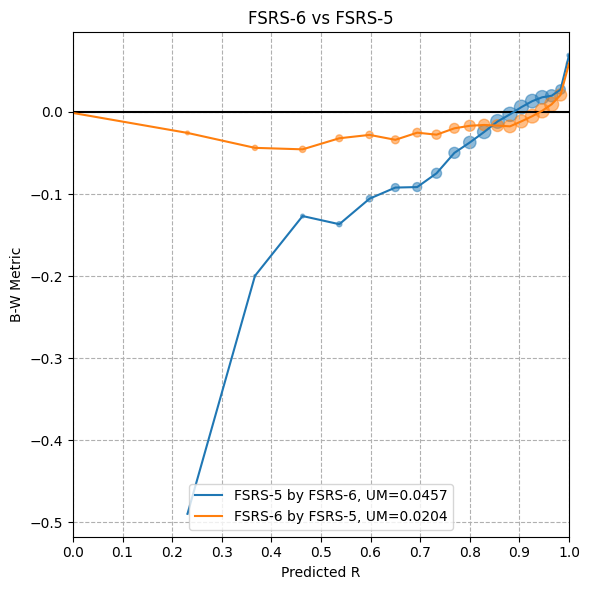

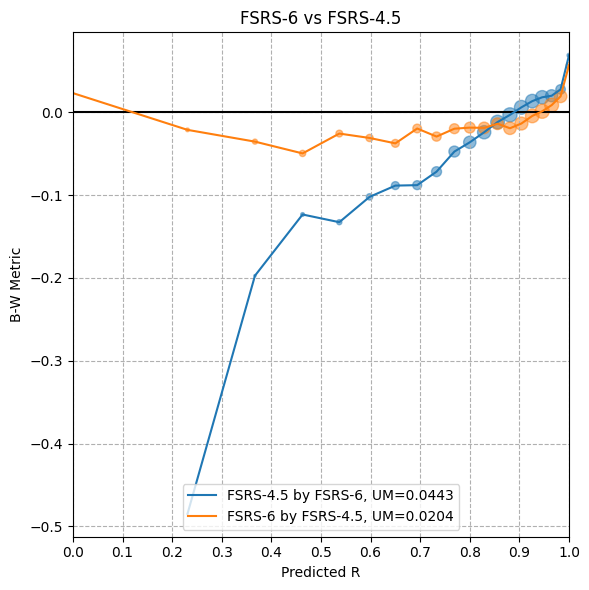

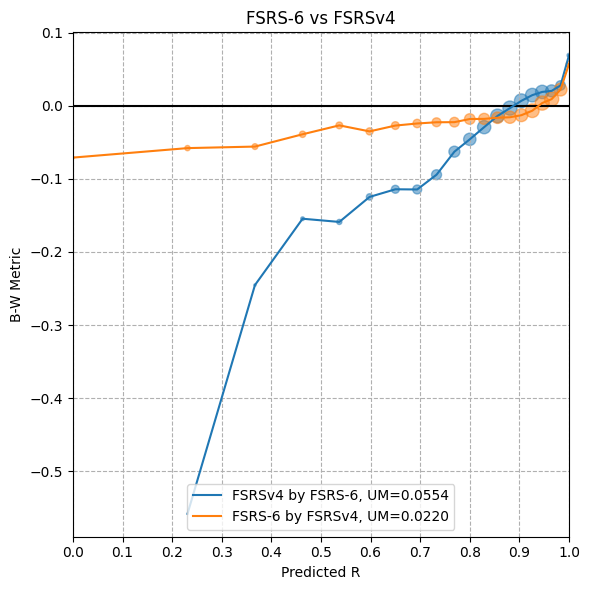

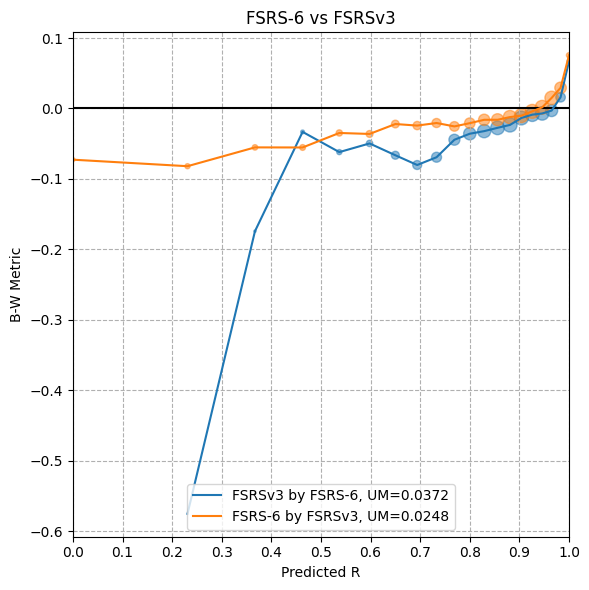

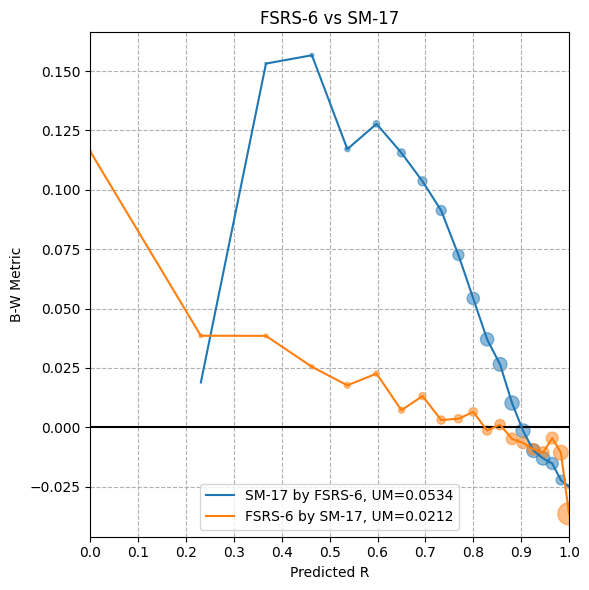

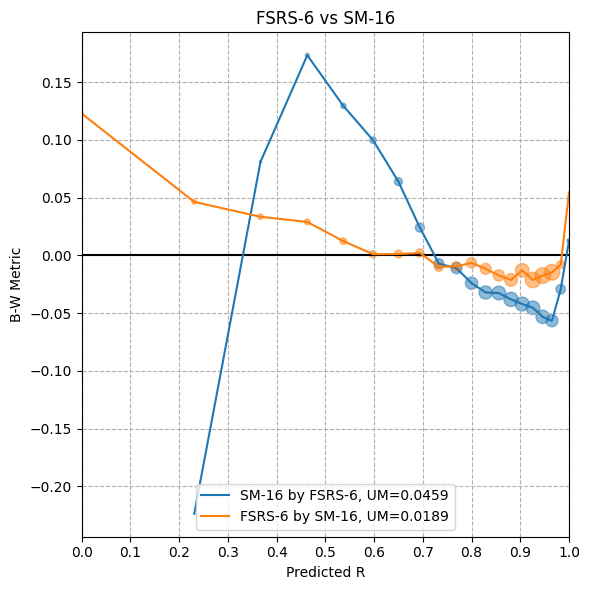

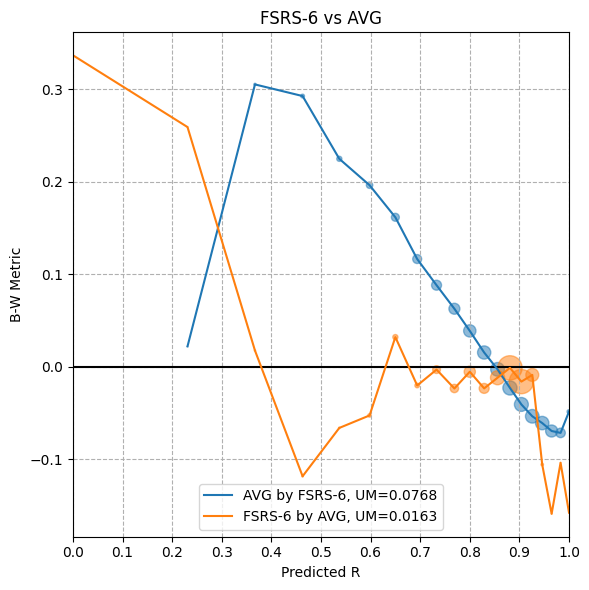

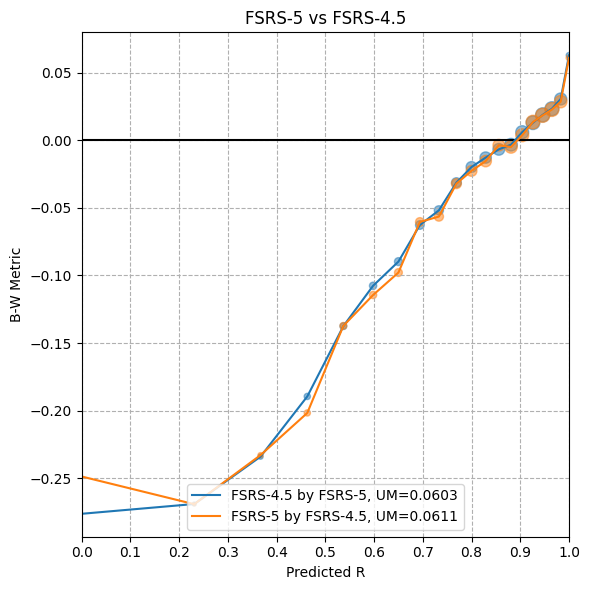

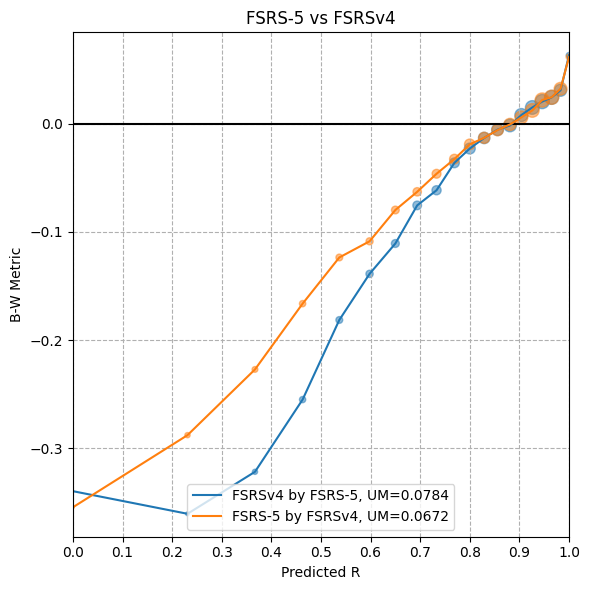

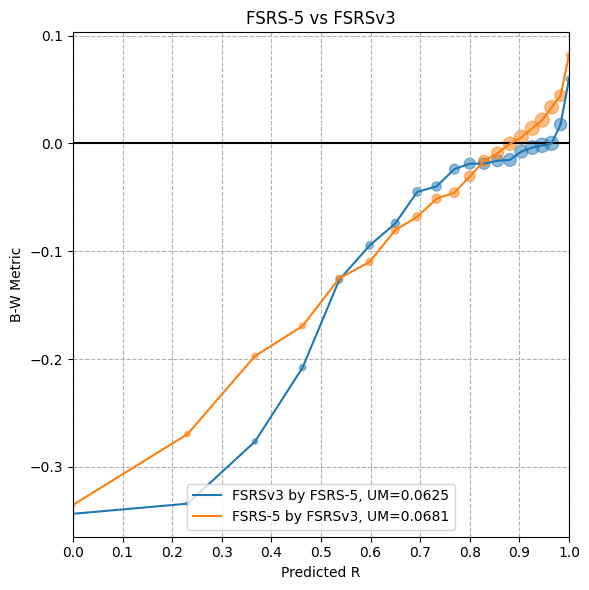

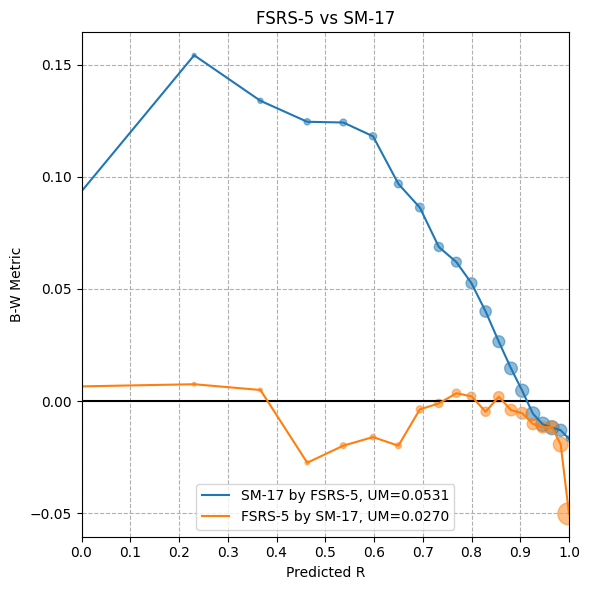

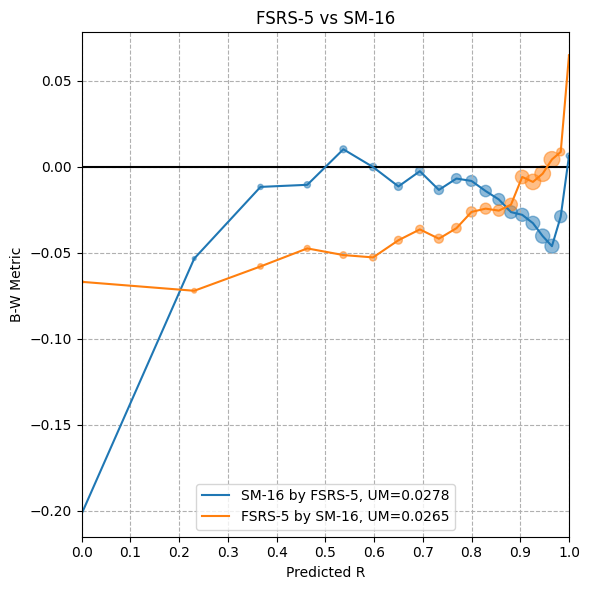

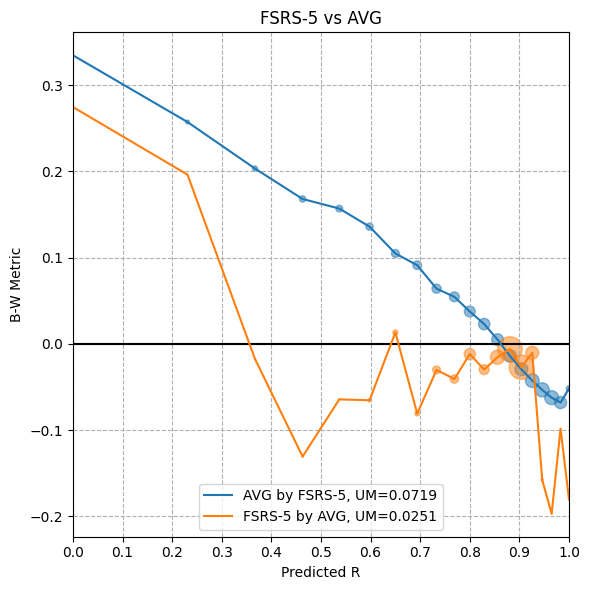

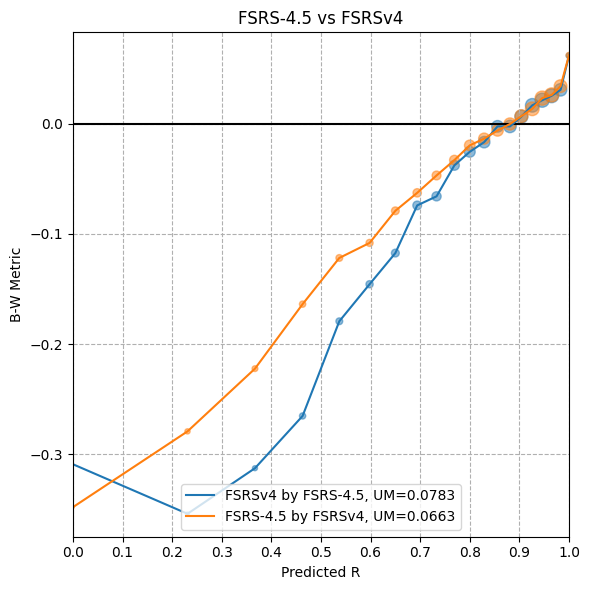

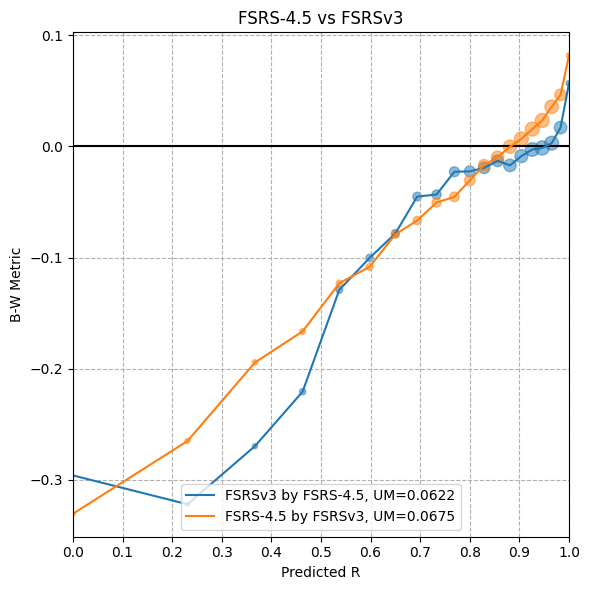

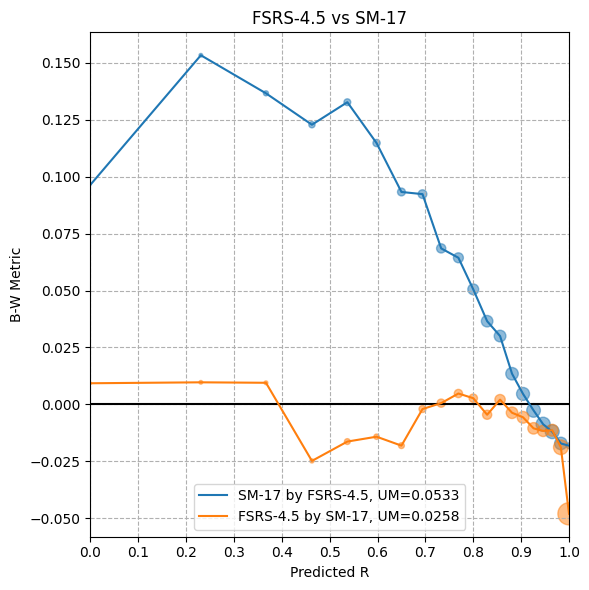

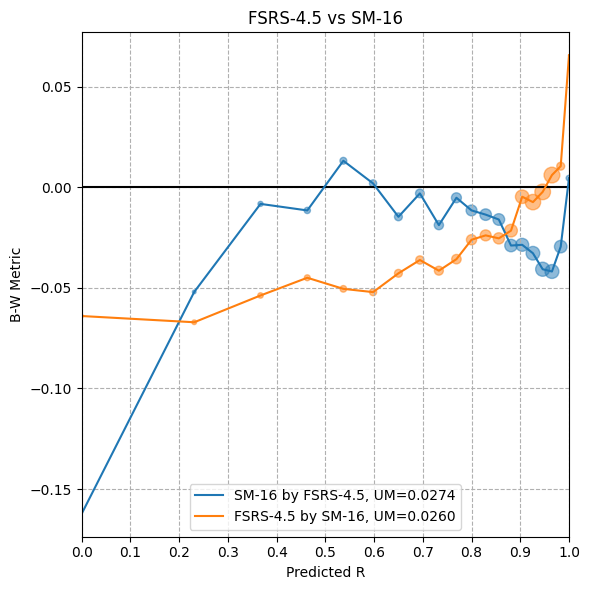

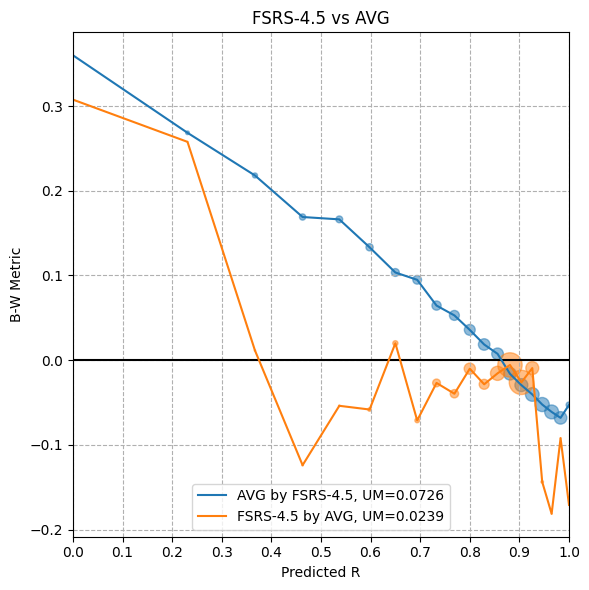

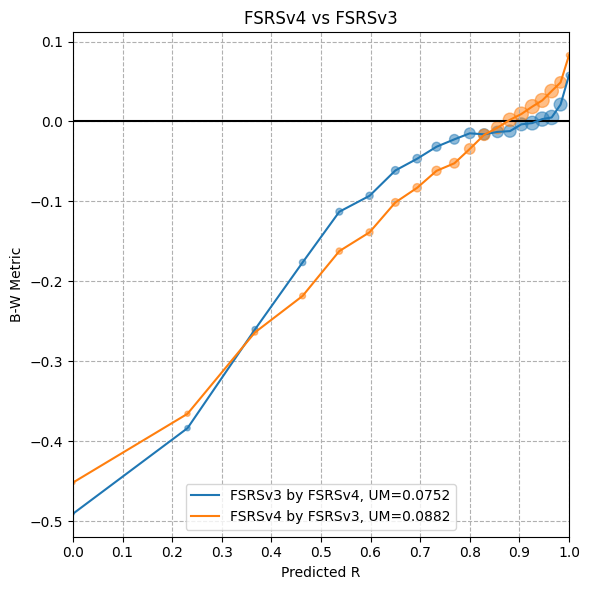

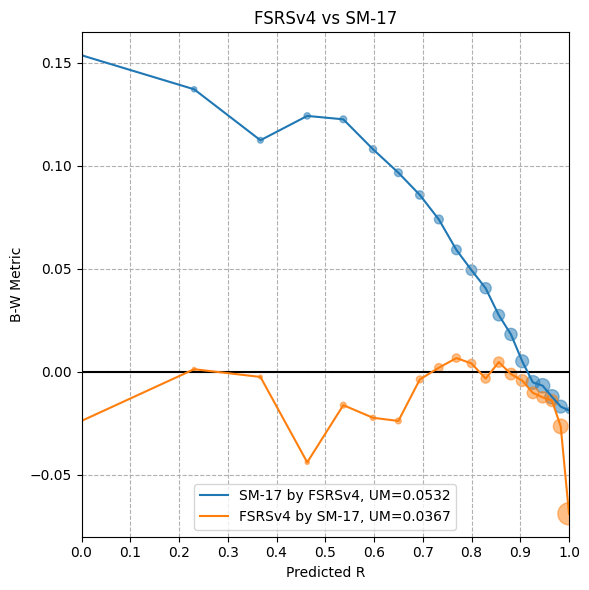

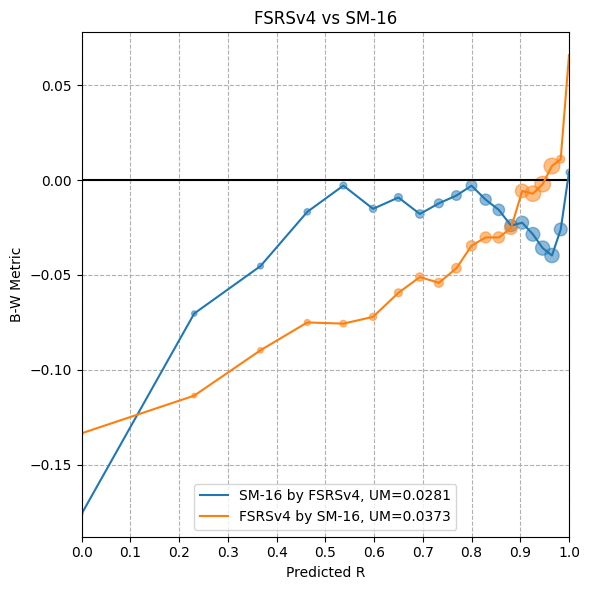

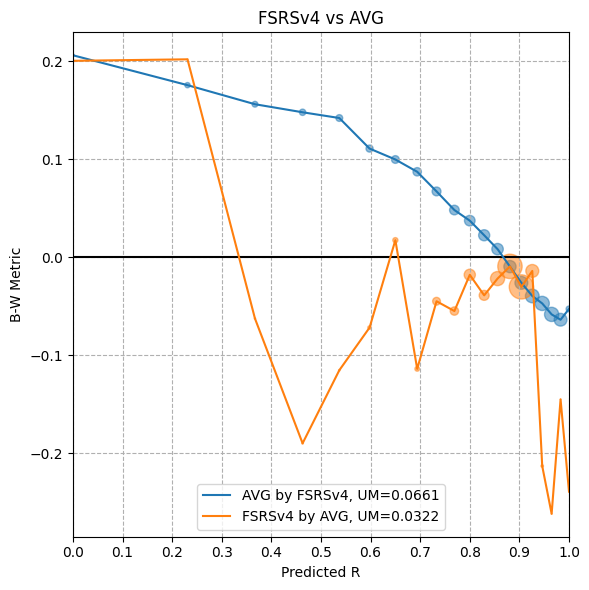

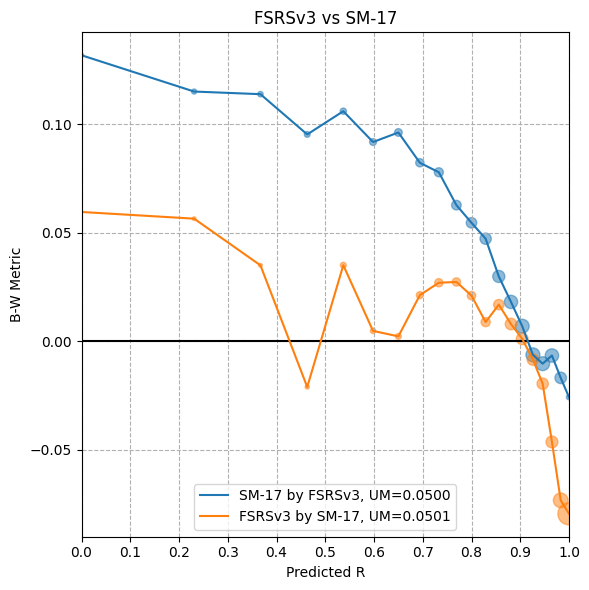

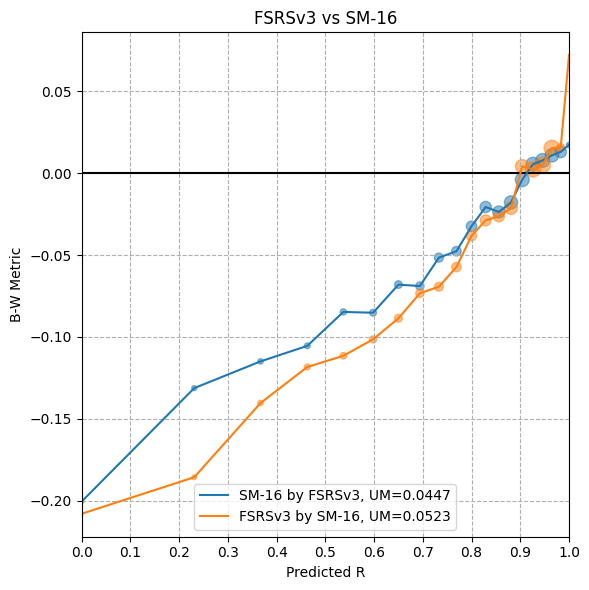

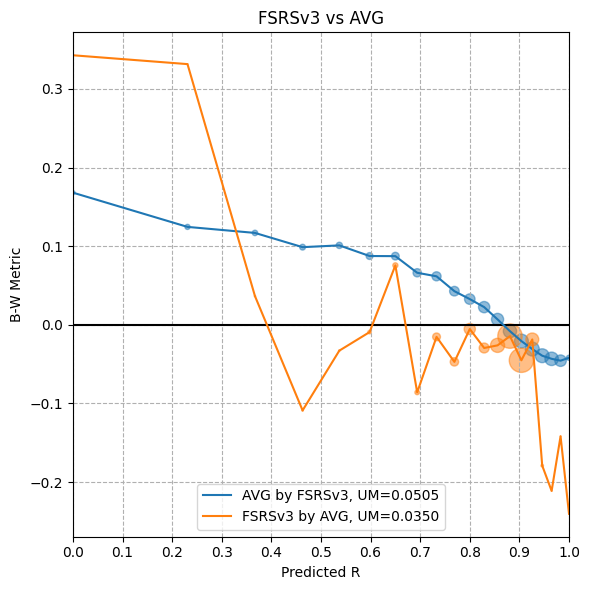

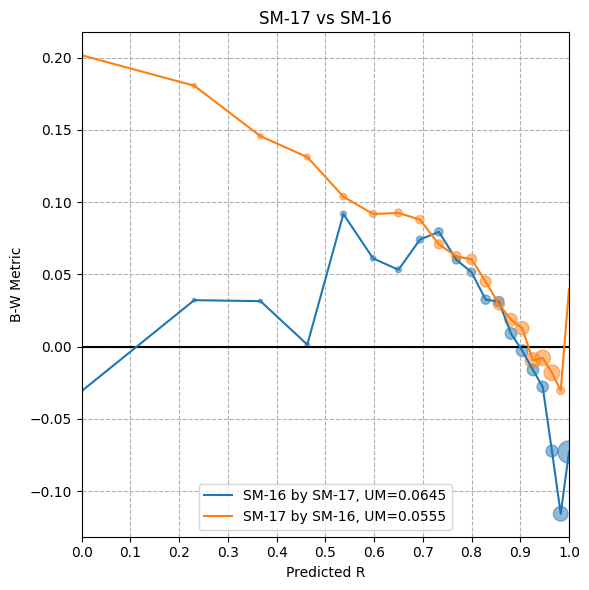

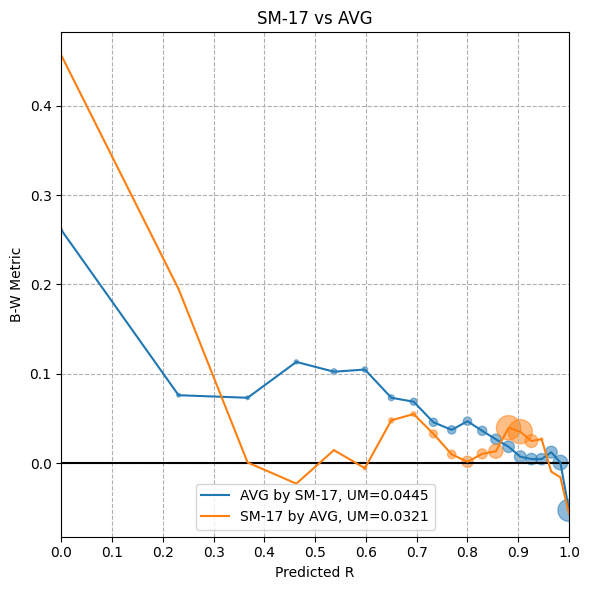

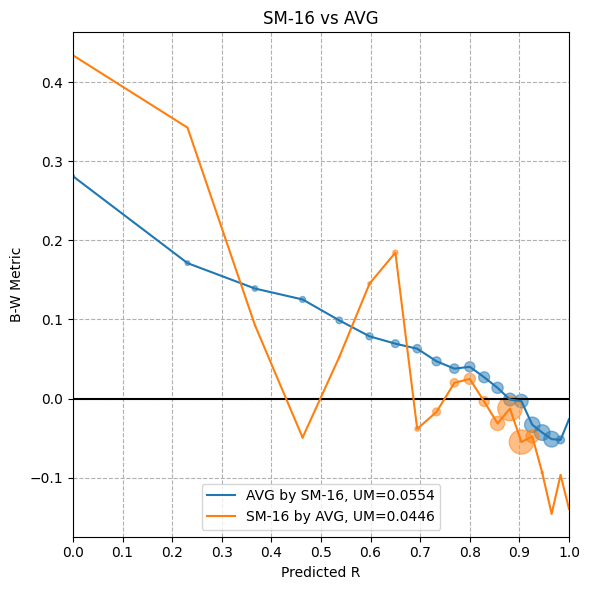

[{'FSRS-5_evaluated_by_FSRS-6': 0.0457, 'FSRS-6_evaluated_by_FSRS-5': 0.0204},
 {'FSRS-4.5_evaluated_by_FSRS-6': 0.0443,
  'FSRS-6_evaluated_by_FSRS-4.5': 0.0204},
 {'FSRSv4_evaluated_by_FSRS-6': 0.0554, 'FSRS-6_evaluated_by_FSRSv4': 0.022},
 {'FSRSv3_evaluated_by_FSRS-6': 0.0372, 'FSRS-6_evaluated_by_FSRSv3': 0.0248},
 {'SM-17_evaluated_by_FSRS-6': 0.0534, 'FSRS-6_evaluated_by_SM-17': 0.0212},
 {'SM-16_evaluated_by_FSRS-6': 0.0459, 'FSRS-6_evaluated_by_SM-16': 0.0189},
 {'AVG_evaluated_by_FSRS-6': 0.0768, 'FSRS-6_evaluated_by_AVG': 0.0163},
 {'FSRS-4.5_evaluated_by_FSRS-5': 0.0603,
  'FSRS-5_evaluated_by_FSRS-4.5': 0.0611},
 {'FSRSv4_evaluated_by_FSRS-5': 0.0784, 'FSRS-5_evaluated_by_FSRSv4': 0.0672},
 {'FSRSv3_evaluated_by_FSRS-5': 0.0625, 'FSRS-5_evaluated_by_FSRSv3': 0.0681},
 {'SM-17_evaluated_by_FSRS-5': 0.0531, 'FSRS-5_evaluated_by_SM-17': 0.027},
 {'SM-16_evaluated_by_FSRS-5': 0.0278, 'FSRS-5_evaluated_by_SM-16': 0.0265},
 {'AVG_evaluated_by_FSRS-5': 0.0719, 'FSRS-5_evaluated_b

In [3]:
from utils import cross_comparison
import itertools

results = []

all_algorithms = ["FSRS-6", "FSRS-5", "FSRS-4.5", "FSRSv4", "FSRSv3", "SM-17", "SM-16", "AVG"]

for player, referee in itertools.combinations(all_algorithms, 2):
    results.append(cross_comparison(df, player, referee))
results

In [4]:
import numpy as np

final_results = {}

for player in all_algorithms:
    universal_metrics = []
    for result in results:
        for key, value in result.items():
            if key.startswith(player):
                universal_metrics.append(value)
    final_results[player] = np.array(universal_metrics).mean().round(4)

# Sort by value (ascending, lower is better)
sorted_results = sorted(final_results.items(), key=lambda x: x[1])

# Display result in markdown table format, bold the best algorithm and its metric
print("| Algorithm | Universal Metric↓ |")
print("|-----------|------------------|")
for i, (algo, metric) in enumerate(sorted_results):
    if i == 0:
        print(f"| **{algo}** | **{metric:.4f}** |")
    else:
        print(f"| {algo} | {metric:.4f} |")

| Algorithm | Universal Metric↓ |
|-----------|------------------|
| **FSRS-6** | **0.0206** |
| SM-16 | 0.0404 |
| FSRS-4.5 | 0.0449 |
| FSRS-5 | 0.0458 |
| SM-17 | 0.0501 |
| FSRSv3 | 0.0535 |
| FSRSv4 | 0.0581 |
| AVG | 0.0625 |
